In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import random

### Load Data and Prepare

In [2]:
def load_mnist_pairs():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_data = np.concatenate([x_train, x_test])
    y_data = np.concatenate([y_train, y_test])
    x_data = x_data.astype("float32") / 255.0
    x_data = np.expand_dims(x_data, axis=-1)

    digit_indices = [np.where(y_data == i)[0] for i in range(10)]

    # Create pairs
    pairs, labels = [], []
    for _ in range(30000):
        # Positive pair
        digit = random.randint(0, 9)
        idx1, idx2 = np.random.choice(digit_indices[digit], 2, replace=False)
        pairs.append([x_data[idx1], x_data[idx2]])
        labels.append(1)

        # Negative pair
        d1, d2 = random.sample(range(10), 2)
        idx1 = np.random.choice(digit_indices[d1])
        idx2 = np.random.choice(digit_indices[d2])
        pairs.append([x_data[idx1], x_data[idx2]])
        labels.append(0)

    return np.array(pairs), np.array(labels).astype("float32")


### pair visualization

In [3]:
pairs, labels = load_mnist_pairs()

# Get positive and negative pairs
positive_pairs = pairs[labels == 1]
negative_pairs = pairs[labels == 0]

# Print their shapes
print("Total Pairs:", pairs.shape)   # (total_pairs, images_per_pair, image_height, image_width, channels)
print("Positive Pairs Shape:", positive_pairs.shape)
print("Negative Pairs Shape:", negative_pairs.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Total Pairs: (60000, 2, 28, 28, 1)
Positive Pairs Shape: (30000, 2, 28, 28, 1)
Negative Pairs Shape: (30000, 2, 28, 28, 1)


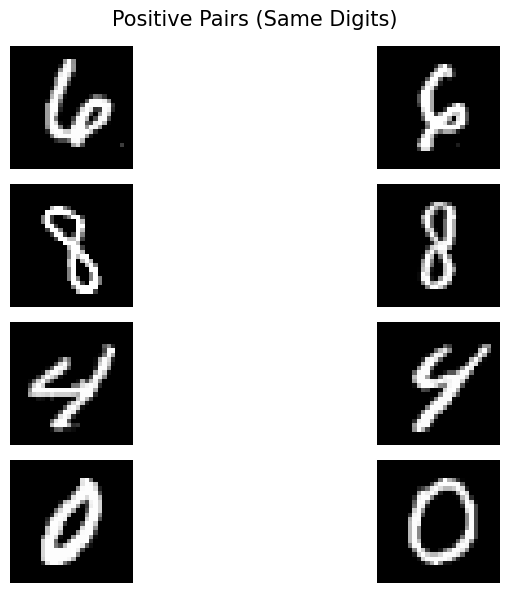

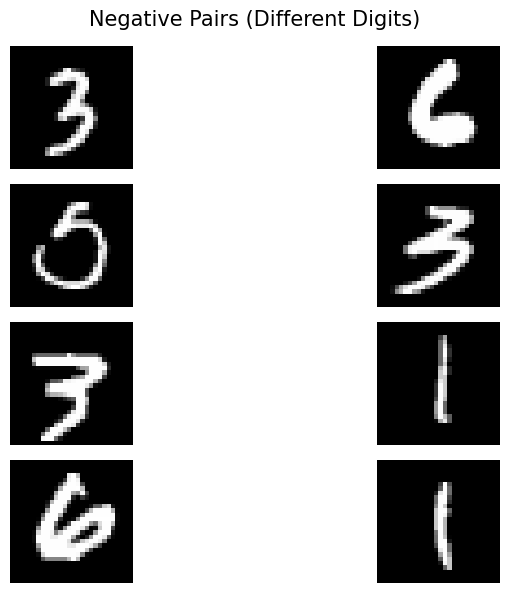

In [4]:
# Load data
pairs, labels = load_mnist_pairs()

# Get 4 positive and 4 negative pairs
positive_pairs = pairs[labels == 1][:4]
negative_pairs = pairs[labels == 0][:4]

# Function to plot a vertical stack of digit pairs (bottom-up style)
def plot_vertical_pairs(pairs, title):
    plt.figure(figsize=(10, 6))
    plt.suptitle(title, fontsize=15)
    for i in range(4):
        # We reverse the order (bottom-up)
        index = 3 - i
        pair = pairs[index]

        # First image (top in vertical stack)
        plt.subplot(4, 2, 2*i + 1)
        plt.imshow(pair[0].squeeze(), cmap='gray')
        plt.axis('off')

        # Second image (bottom in vertical stack)
        plt.subplot(4, 2, 2*i + 2)
        plt.imshow(pair[1].squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
# Plot positive and negative pairs
plot_vertical_pairs(positive_pairs, "Positive Pairs (Same Digits)")
plot_vertical_pairs(negative_pairs, "Negative Pairs (Different Digits)")

### Define the Model

In [5]:
def create_base_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    return models.Model(input, x)


### BCE Siamese Model

In [6]:
def build_bce_model(input_shape):
    base_network = create_base_network(input_shape)
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    emb_a = base_network(input_a)
    emb_b = base_network(input_b)

    x = layers.concatenate([emb_a, emb_b])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([input_a, input_b], x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Epoch 1/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7185 - loss: 0.5038 - val_accuracy: 0.9654 - val_loss: 0.1120
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9785 - loss: 0.0755 - val_accuracy: 0.9828 - val_loss: 0.0540
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9921 - loss: 0.0288 - val_accuracy: 0.9889 - val_loss: 0.0342
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9954 - loss: 0.0171 - val_accuracy: 0.9920 - val_loss: 0.0252
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9977 - loss: 0.0090 - val_accuracy: 0.9910 - val_loss: 0.0305
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9970 - loss: 0.0104 - val_accuracy: 0.9917 - val_loss: 0.0277
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9980 - loss: 0.0062 - val_accuracy: 0.9920 - val_loss: 0.0264
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9991 - loss: 0.0041 -

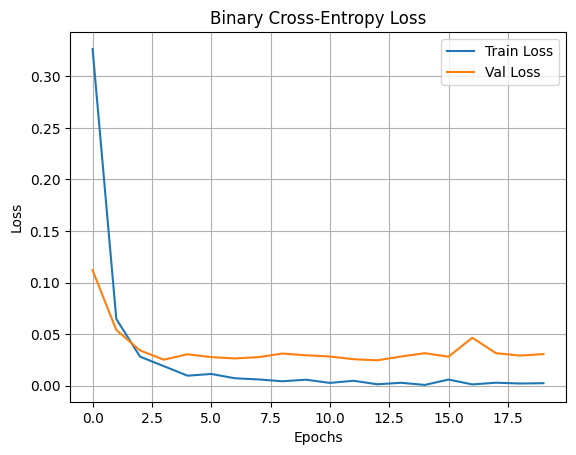

In [7]:
pairs, labels = load_mnist_pairs()
input_shape = pairs[0][0].shape

# Split data
x_train, x_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2)

# BCE
bce_model = build_bce_model(input_shape)
history_bce = bce_model.fit([x_train[:,0], x_train[:,1]], y_train, validation_split=0.2, epochs=20)

#ploting the history
plt.plot(history_bce.history['loss'], label='Train Loss')
plt.plot(history_bce.history['val_loss'], label='Val Loss')
plt.title("Binary Cross-Entropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


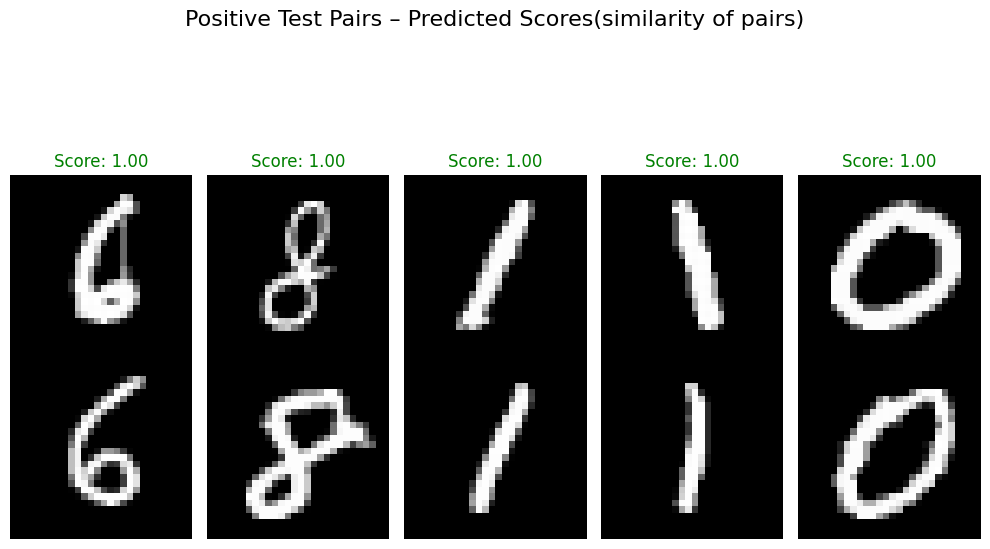

In [93]:
# Select 5 random positive test pairs
pos_indices = np.where(y_test == 1)[0]
selected_indices = np.random.choice(pos_indices, 5, replace=False)
selected_pairs = x_test[selected_indices]

# Predict similarity scores
pred_scores = bce_model.predict([selected_pairs[:, 0], selected_pairs[:, 1]])

# Plot in 2x5 grid
plt.figure(figsize=(10, 6))
for i in range(5):
    img1 = selected_pairs[i][0].squeeze()
    img2 = selected_pairs[i][1].squeeze()
    score = pred_scores[i][0]

    # Prediction with score
    plt.subplot(1, 5, i+1)
    plt.imshow(np.vstack([img1, img2]), cmap='gray')
    plt.title(f"Score: {score:.2f}", color='green' if score > 0.5 else 'red')
    plt.axis('off')

plt.suptitle("Positive Test Pairs – Predicted Scores(similarity of pairs)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


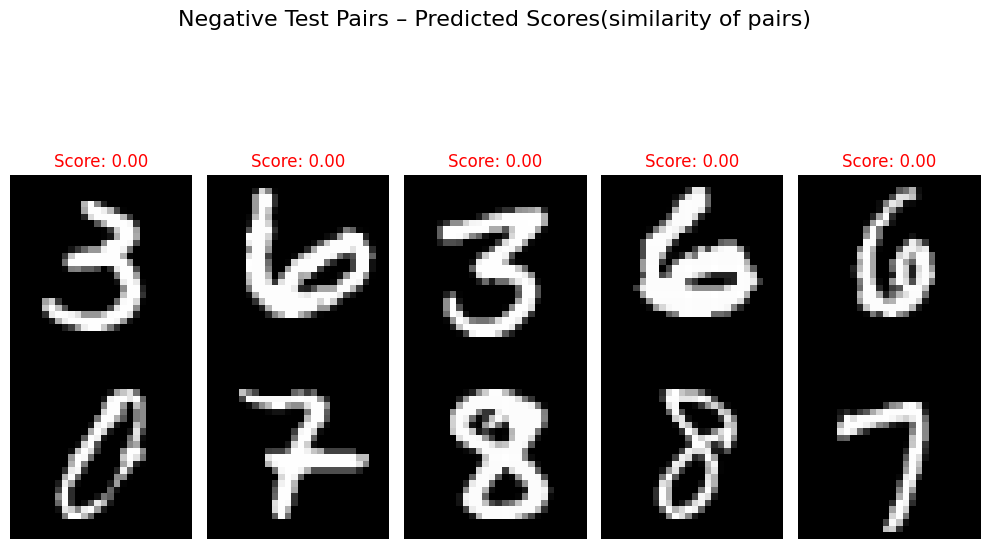

In [96]:
# Select 5 random negative test pairs
neg_indices = np.where(y_test == 0)[0]
selected_indices = np.random.choice(neg_indices, 5, replace=False)
selected_pairs = x_test[selected_indices]

# Predict similarity scores
pred_scores = bce_model.predict([selected_pairs[:, 0], selected_pairs[:, 1]])

# Plot in 1x5 grid
plt.figure(figsize=(10, 6))
for i in range(5):
    img1 = selected_pairs[i][0].squeeze()
    img2 = selected_pairs[i][1].squeeze()
    score = pred_scores[i][0]

    # Prediction with score
    plt.subplot(1, 5, i+1)
    plt.imshow(np.vstack([img1, img2]), cmap='gray')
    plt.title(f"Score: {score:.2f}", color='green' if score > 0.5 else 'red')
    plt.axis('off')

plt.suptitle("Negative Test Pairs – Predicted Scores(similarity of pairs)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


### Contrastive Siamese Model

In [111]:
def contrastive_loss(y_true, y_pred):
    margin = tf.constant(1.0, dtype=tf.float32)
    squared_pred = tf.square(y_pred)
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * squared_pred + (1 - y_true) * margin_squared)

def build_contrastive_model(input_shape):
    base_network = create_base_network(input_shape)
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    emb_a = base_network(input_a)
    emb_b = base_network(input_b)

    # Add epsilon inside sqrt to avoid NaN
    epsilon = 1e-6
    l2_distance = layers.Lambda(
        lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True) + epsilon)
    )([emb_a, emb_b])

    model = models.Model([input_a, input_b], l2_distance)
    model.compile(loss=contrastive_loss, optimizer='adam')
    return model



Epoch 1/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0826 - val_loss: 0.0276
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0237 - val_loss: 0.0190
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0124 - val_loss: 0.0147
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0101 - val_loss: 0.0144
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0087 - val_loss: 0.0128
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0069 - val_loss: 0.0130
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0063 - val_loss: 0.0123
Epoch 9/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0057 - val_loss: 0.0123
Epoch 10/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0050 - val_loss: 0.0122
Epoch 11/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0047 - val_loss: 0.0128
Epoch 12/20
1200/1200 ━━━━━━━━

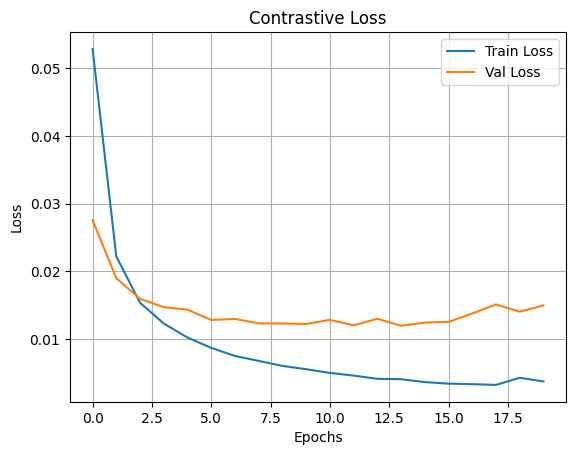

In [112]:
pairs, labels = load_mnist_pairs()
input_shape = pairs[0][0].shape
pairs = np.array(pairs)
labels = np.array(labels)

# Split data
x_train, x_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2)

# Contrastive
contrast_model = build_contrastive_model(input_shape)
history_contrast = contrast_model.fit([x_train[:,0], x_train[:,1]], y_train, validation_split=0.2, epochs=20)

#ploting the history
plt.plot(history_contrast.history['loss'], label='Train Loss')
plt.plot(history_contrast.history['val_loss'], label='Val Loss')
plt.title("Contrastive Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


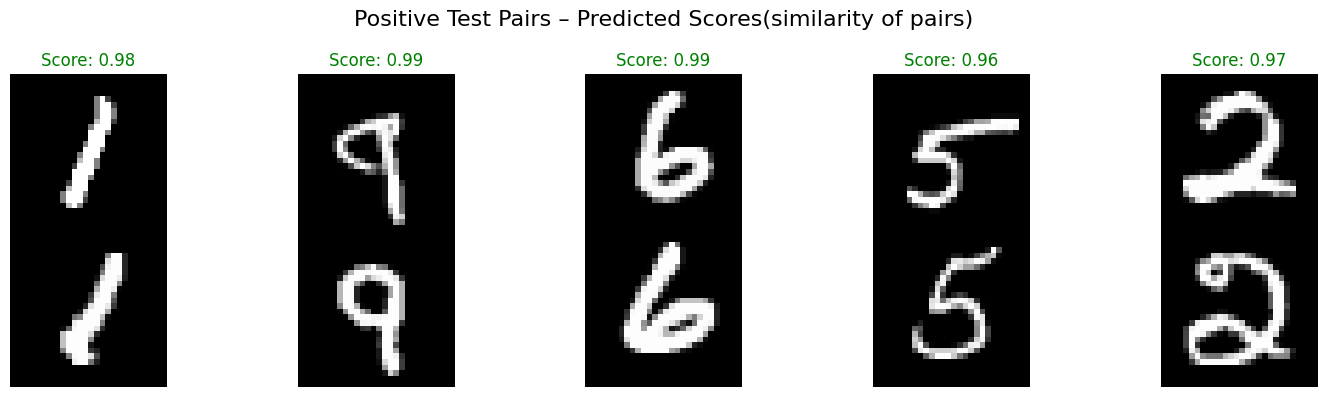

In [121]:
# Select 5 random positive test pairs
pos_indices = np.where(y_test == 1)[0]
selected_indices = np.random.choice(pos_indices, 5, replace=False)
selected_pairs = x_test[selected_indices]

# Predict similarity scores using the Siamese model
pred_scores = contrast_model.predict([selected_pairs[:, 0], selected_pairs[:, 1]])

# Plot 5 positive test pairs with similarity scores
plt.figure(figsize=(15, 4))
for i in range(5):
    img1 = selected_pairs[i][0].squeeze()
    img2 = selected_pairs[i][1].squeeze()
    distance = pred_scores[i][0]

    # Convert distance to similarity score in [0, 1]
    similarity = 1 / (1 + distance)

    # Plot vertically stacked pair
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.vstack([img1, img2]), cmap='gray')
    plt.title(f"Score: {similarity:.2f}", color='green' if similarity > 0.5 else 'red')
    plt.axis('off')

plt.suptitle("Positive Test Pairs – Predicted Scores(similarity of pairs)", fontsize=16)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


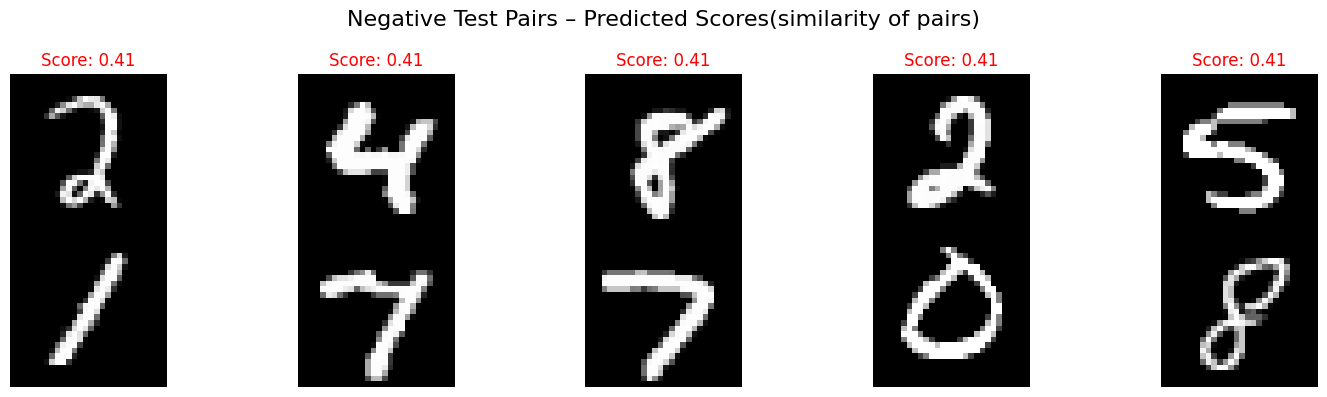

In [129]:
# Select 5 random negative test pairs
neg_indices = np.where(y_test == 0)[0]
selected_indices = np.random.choice(neg_indices, 5, replace=False)
selected_pairs = x_test[selected_indices]

# Predict similarity scores
pred_scores = contrast_model.predict([selected_pairs[:, 0], selected_pairs[:, 1]])

# Plot 5 positive test pairs with similarity scores
plt.figure(figsize=(15, 4))
for i in range(5):
    img1 = selected_pairs[i][0].squeeze()
    img2 = selected_pairs[i][1].squeeze()
    distance = pred_scores[i][0]

    # Convert distance to similarity score in [0, 1]
    similarity = 1 / (1 + distance)

    # Plot vertically stacked pair
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.vstack([img1, img2]), cmap='gray')
    plt.title(f"Score: {similarity:.2f}", color='green' if similarity > 0.5 else 'red')
    plt.axis('off')

plt.suptitle("Negative Test Pairs – Predicted Scores(similarity of pairs)", fontsize=16)
plt.tight_layout()
plt.show()

### Triplet Siamese Model

In [132]:
#Dataset preparation for triplet loss function
def generate_triplets(images, labels, label_to_indices, num_triplets=10000):
    triplets = []
    for _ in range(num_triplets):
        anchor_label = np.random.choice(np.unique(labels))
        positive_label = anchor_label
        negative_label = np.random.choice([l for l in np.unique(labels) if l != anchor_label])

        anchor_idx = np.random.choice(label_to_indices[anchor_label])
        positive_idx = np.random.choice(label_to_indices[positive_label])
        negative_idx = np.random.choice(label_to_indices[negative_label])

        anchor_img = images[anchor_idx]
        positive_img = images[positive_idx]
        negative_img = images[negative_idx]

        triplets.append((anchor_img, positive_img, negative_img))

    triplets = np.array(triplets)
    return triplets

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


# Group training images by label
def create_label_index_dict(images, labels):
    label_to_indices = {}
    for idx, label in enumerate(labels):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(idx)
    return label_to_indices


train_dict = create_label_index_dict(x_train, y_train)
test_dict = create_label_index_dict(x_test, y_test)

# Generate 20K training and 5K test triplets
train_triplets = generate_triplets(x_train, y_train, train_dict, num_triplets=20000)
test_triplets = generate_triplets(x_test, y_test, test_dict, num_triplets=5000)

# Split into anchor, positive, negative
x_anchor_train = train_triplets[:, 0]
x_positive_train = train_triplets[:, 1]
x_negative_train = train_triplets[:, 2]

x_anchor_test = test_triplets[:, 0]
x_positive_test = test_triplets[:, 1]
x_negative_test = test_triplets[:, 2]

print(f"Printing the shape of the training samples")
print(x_anchor_train.shape)
print(x_positive_train.shape)
print(x_negative_train.shape)

print(f"Printing the shape of the test samples")
print(x_anchor_test.shape)
print(x_positive_test.shape)
print(x_negative_test.shape)

Printing the shape of the training samples
(20000, 28, 28, 1)
(20000, 28, 28, 1)
(20000, 28, 28, 1)
Printing the shape of the test samples
(5000, 28, 28, 1)
(5000, 28, 28, 1)
(5000, 28, 28, 1)


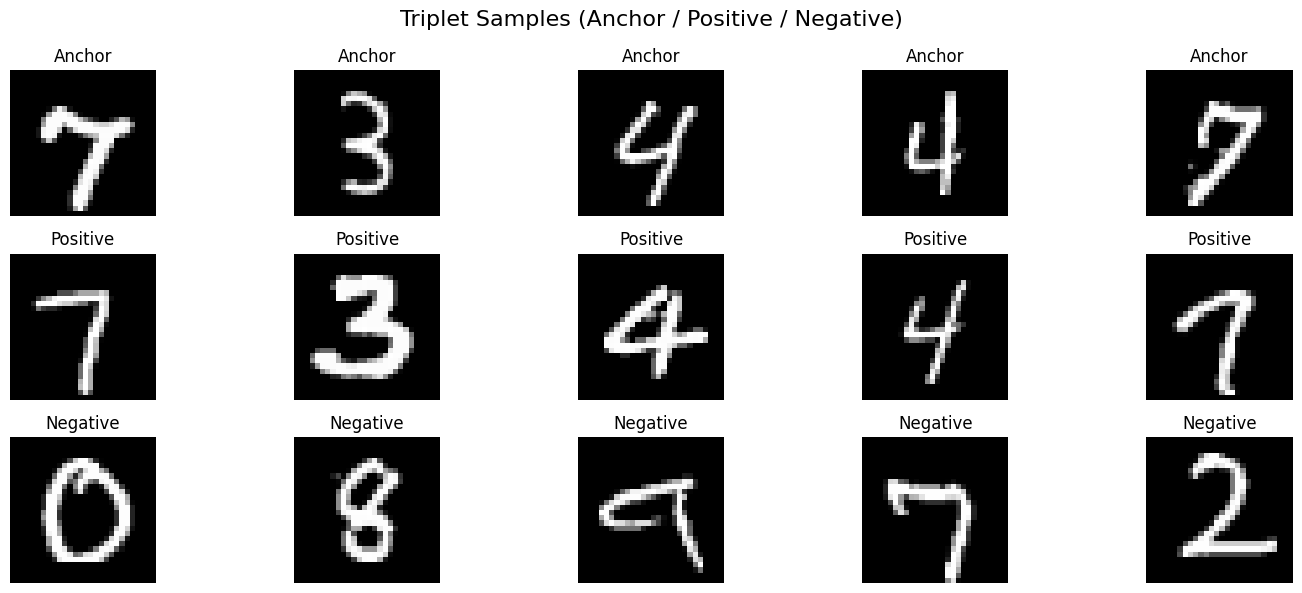

In [133]:
# Select 5 random triplet indices
num_samples = 5
indices = np.random.choice(len(x_anchor_train), num_samples, replace=False)

# Plot 3 rows: Anchor, Positive, Negative
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    anchor_img = x_anchor_train[idx].squeeze()
    positive_img = x_positive_train[idx].squeeze()
    negative_img = x_negative_train[idx].squeeze()

    # Anchor (Row 1)
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(anchor_img, cmap='gray')
    plt.title("Anchor")
    plt.axis('off')

    # Positive (Row 2)
    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(positive_img, cmap='gray')
    plt.title("Positive")
    plt.axis('off')

    # Negative (Row 3)
    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(negative_img, cmap='gray')
    plt.title("Negative")
    plt.axis('off')

plt.suptitle("Triplet Samples (Anchor / Positive / Negative)", fontsize=16)
plt.tight_layout()
plt.show()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2159 - val_loss: 0.0363
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0307 - val_loss: 0.0273
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0258 - val_loss: 0.0167
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0118 - val_loss: 0.0179
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0127 - val_loss: 0.0146
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0087 - val_loss: 0.0171
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067 - val_loss: 0.0152
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0053 - val_loss: 0.0159
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0041 - val_loss: 0.0120
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0046 - val_loss: 0.0143
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0046 - val_loss: 0.0150
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/ste

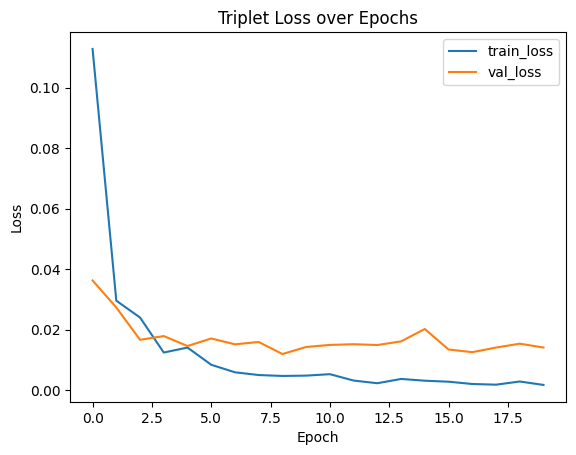

In [138]:
# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        # Reshape to (batch_size, 3, embedding_dim)
        embedding_dim = tf.shape(y_pred)[1] // 3
        y_pred = tf.reshape(y_pred, [-1, 3, embedding_dim])

        anchor   = y_pred[:, 0]
        positive = y_pred[:, 1]
        negative = y_pred[:, 2]

        # Compute squared distances
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

        # Compute triplet loss
        loss_val = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss_val)

    return loss

# Triplet Siamese Model
def build_triplet_model(input_shape):
    base_network = create_base_network(input_shape)

    anchor_input = layers.Input(shape=input_shape, name='anchor')
    positive_input = layers.Input(shape=input_shape, name='positive')
    negative_input = layers.Input(shape=input_shape, name='negative')

    anchor_embedding = base_network(anchor_input)
    positive_embedding = base_network(positive_input)
    negative_embedding = base_network(negative_input)

    merged_output = layers.Concatenate(axis=1)([anchor_embedding, positive_embedding, negative_embedding])
    triplet_model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))
    return triplet_model

# Train model
input_shape = x_anchor_train.shape[1:]  # (28, 28, 1)
triplet_model = build_triplet_model(input_shape)

history = triplet_model.fit(
    [x_anchor_train, x_positive_train, x_negative_train],
    np.zeros(len(x_anchor_train)),  # Dummy y because loss is custom
    validation_data=(
        [x_anchor_test, x_positive_test, x_negative_test],
        np.zeros(len(x_anchor_test))
    ),
    batch_size=64,
    epochs=20
)

#plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Triplet Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


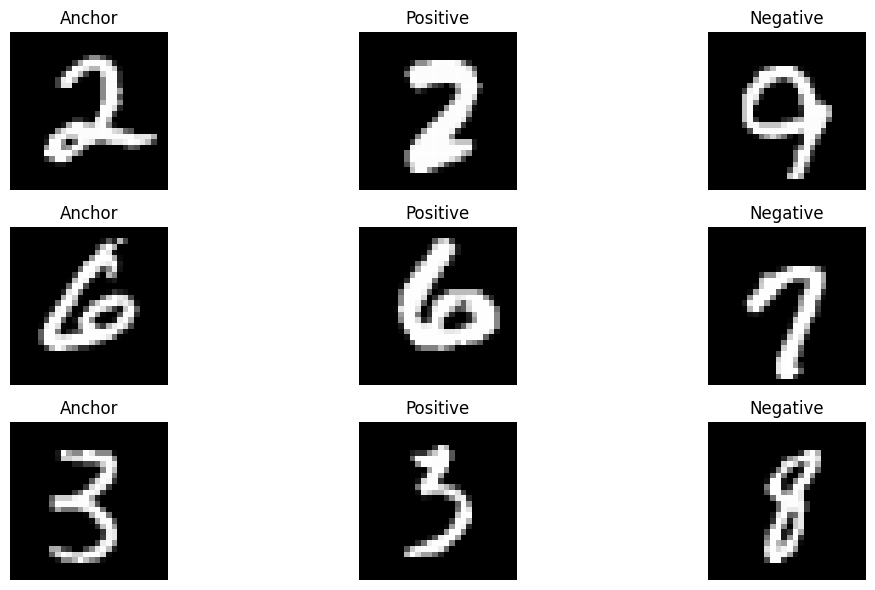


Calculated Distances for the Triplets Above...

Triplet 1:
  Anchor-Positive Distance: 0.0495
  Anchor-Negative Distance: 2.0000
  Result: Correctly separated!

Triplet 2:
  Anchor-Positive Distance: 0.0931
  Anchor-Negative Distance: 2.0000
  Result: Correctly separated!

Triplet 3:
  Anchor-Positive Distance: 0.1834
  Anchor-Negative Distance: 2.0000
  Result: Correctly separated!



In [144]:
num_samples = 3
indices = np.random.choice(len(x_anchor_test), num_samples, replace=False)

# Grab the triplets
anchor_sample   = x_anchor_test[indices]
positive_sample = x_positive_test[indices]
negative_sample = x_negative_test[indices]

# Predict embeddings
y_pred = triplet_model.predict([anchor_sample, positive_sample, negative_sample])
embedding_dim = y_pred.shape[1] // 3
y_pred = y_pred.reshape(-1, 3, embedding_dim)

anchor   = y_pred[:, 0]
positive = y_pred[:, 1]
negative = y_pred[:, 2]

pos_dist = np.sum((anchor - positive) ** 2, axis=1)
neg_dist = np.sum((anchor - negative) ** 2, axis=1)

# Plot images triplet-wise row-wise
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    # Anchor
    plt.subplot(num_samples, 3, 3*i + 1)
    plt.imshow(anchor_sample[i].squeeze(), cmap='gray')
    plt.title("Anchor")
    plt.axis('off')

    # Positive
    plt.subplot(num_samples, 3, 3*i + 2)
    plt.imshow(positive_sample[i].squeeze(), cmap='gray')
    plt.title("Positive")
    plt.axis('off')

    # Negative
    plt.subplot(num_samples, 3, 3*i + 3)
    plt.imshow(negative_sample[i].squeeze(), cmap='gray')
    plt.title("Negative")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print calculated distances and results
print("\nCalculated Distances for the Triplets Above...\n")
for i in range(num_samples):
    print(f"Triplet {i+1}:")
    print(f"  Anchor-Positive Distance: {pos_dist[i]:.4f}")
    print(f"  Anchor-Negative Distance: {neg_dist[i]:.4f}")
    if pos_dist[i] + 1.0 < neg_dist[i]:
        print("  Result: Correctly separated!\n")
    else:
        print("  Result: Incorrectly separated.\n")
